# Load Dependencies

In [14]:
import pandas as pd
import numpy as np
import glob
import dgl
import torch
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import Parameter
from rdkit import Chem
from script_baseline.Baseline_MG import get_mg_nodes_feat,Get_Baseline_MG_feat
from script_baseline.GCN import GCN2
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt

# Load Data

In [2]:
data_file = '../data2/data2.csv'
mol_dir = '../data2/data2_sdf_files/'
tmp_df = pd.read_csv(data_file)
labels_ori = np.array(tmp_df['Output'].to_list())

In [3]:
def sort_func(x): return eval(x.split('/')[-1].split('.')[0].split('_')[-1])
cat_files = sorted(glob.glob('../data2/data2_sdf_files/cat_*.sdf'),key=sort_func)
imine_files = sorted(glob.glob('../data2/data2_sdf_files/imine_*.sdf'),key=sort_func)
thiol_files = sorted(glob.glob('../data2/data2_sdf_files/thiol_*.sdf'),key=sort_func)

with open(mol_dir+'smiles_file_dict.csv','r') as fr:
    lines = fr.readlines()
smiles_name_dict = {tmp_line.strip().split(',')[0]:tmp_line.strip().split(',')[1] for tmp_line in lines}

# Generate Baseline MG

In [4]:
imine_Graph_name_dict=Get_Baseline_MG_feat(imine_files)

../data2/data2_sdf_files/imine_0.sdf
../data2/data2_sdf_files/imine_1.sdf
../data2/data2_sdf_files/imine_2.sdf
../data2/data2_sdf_files/imine_3.sdf
../data2/data2_sdf_files/imine_4.sdf


In [6]:
cat_Graph_name_dict=Get_Baseline_MG_feat(cat_files)

../data2/data2_sdf_files/cat_0.sdf
../data2/data2_sdf_files/cat_1.sdf
../data2/data2_sdf_files/cat_2.sdf
../data2/data2_sdf_files/cat_3.sdf
../data2/data2_sdf_files/cat_4.sdf
../data2/data2_sdf_files/cat_5.sdf
../data2/data2_sdf_files/cat_6.sdf
../data2/data2_sdf_files/cat_7.sdf
../data2/data2_sdf_files/cat_8.sdf
../data2/data2_sdf_files/cat_9.sdf
../data2/data2_sdf_files/cat_10.sdf
../data2/data2_sdf_files/cat_11.sdf
../data2/data2_sdf_files/cat_12.sdf
../data2/data2_sdf_files/cat_13.sdf
../data2/data2_sdf_files/cat_14.sdf
../data2/data2_sdf_files/cat_15.sdf
../data2/data2_sdf_files/cat_16.sdf
../data2/data2_sdf_files/cat_17.sdf
../data2/data2_sdf_files/cat_18.sdf
../data2/data2_sdf_files/cat_19.sdf
../data2/data2_sdf_files/cat_20.sdf
../data2/data2_sdf_files/cat_21.sdf
../data2/data2_sdf_files/cat_22.sdf
../data2/data2_sdf_files/cat_23.sdf
../data2/data2_sdf_files/cat_24.sdf
../data2/data2_sdf_files/cat_25.sdf
../data2/data2_sdf_files/cat_26.sdf
../data2/data2_sdf_files/cat_27.sdf
..

In [7]:
thiol_Graph_name_dict=Get_Baseline_MG_feat(thiol_files)

../data2/data2_sdf_files/thiol_0.sdf
../data2/data2_sdf_files/thiol_1.sdf
../data2/data2_sdf_files/thiol_2.sdf
../data2/data2_sdf_files/thiol_3.sdf
../data2/data2_sdf_files/thiol_4.sdf


# Load Graph Dataset

In [8]:
class Graph_DataSet(Dataset):

    def __init__(self, root,csv_dir,sdf_dir, train=True, transform = None, target_transform=None):
        super(Graph_DataSet, self).__init__()
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

        if self.train :
            file_annotation = root + csv_dir
            sdf_folder = root +sdf_dir
        else:
            file_annotation = root +csv_dir
            sdf_folder = root + sdf_dir
        df = pd.read_csv(file_annotation)
        target = np.array(df['Output'].to_list())
        self.target_min = target.min()
        self.target_range = target.max() - target.min()
        
        target_std = (target - target.min())/(target.max()-target.min())
        
        cat_smi = df['Catalyst'].to_list()
        imine_smi = df['Imine'].to_list()
        thiol_smi = df['Thiol'].to_list()
        
        
        cat_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in cat_smi]
        imine_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in imine_smi]
        thiol_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in thiol_smi]
        
        self.cat_file_names = cat_file_names
        self.imine_file_names = imine_file_names
        self.thiol_file_names = thiol_file_names
        
        self.target_std = target_std
        self.sdf_folder = sdf_folder
            
    def __getitem__(self, index):
        cat_name = self.cat_file_names[index]
        imine_name = self.imine_file_names[index]
        thiol_name = self.thiol_file_names[index]
        label = self.target_std[index]

        graph_1 = cat_Graph_name_dict[cat_name]
        graph_2 = imine_Graph_name_dict[imine_name]
        graph_3 = thiol_Graph_name_dict[thiol_name]
        
        return [graph_1,graph_1.ndata['feat'],graph_2,graph_2.ndata['feat'],graph_3,graph_3.ndata['feat']], label

    def __len__(self):
        return len(self.target_std)

# Train Model

In [9]:
loss = 'mse'
batch_size = 128
shuffle = np.array(list(range(1075)))
np.random.shuffle(shuffle)
train_index = shuffle[:600]
val_index = shuffle[600:]
dataset = Graph_DataSet('../data2',csv_dir='/data2.csv' , sdf_dir='/data2_sdf_files/')
train_data=[]
for i in train_index:
    tem_data=dataset[i]
    train_data.append(tem_data)
    
val_data=[]
for i in val_index:
    tem_data=dataset[i]
    val_data.append(tem_data)     

In [10]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
model = GCN2(15,256,1)
optimizer = optim.Adam(model.parameters())
loss_func = torch.nn.L1Loss()

checkpoint=ModelCheckpoint("../Dataset/run_data/model_cusgraph.hdf5",
                               verbose=0,monitor='loss',
                               save_best_only=True,mode='min')
for epoch in range(50):
    get_output=[]
    all_loss = []
    model.train()
    for i, data in enumerate(train_data):
        inputs, labels = data
        outputs = model(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],)
        get_output.append(outputs)

        labels = torch.tensor(labels) 
        
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        all_loss.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
    print('Train MSE',np.mean(all_loss))
    model.eval()
    test_get_output=[]
    test_all_labels = []
    all_loss = []
    for data in val_data:
        inputs, labels = data
        outputs = model(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],)
        test_get_output.append(outputs)
        labels = torch.tensor(labels) 
        test_all_labels.append(labels)
        loss = loss_func(outputs, labels)
        all_loss.append(loss.detach().numpy())
    print('Test MSE',np.mean(all_loss))   

Train MSE 0.16268572
Test MSE 0.15833503
Train MSE 0.16033559
Test MSE 0.1583208
Train MSE 0.15994166
Test MSE 0.15778978
Train MSE 0.15953603
Test MSE 0.15663289
Train MSE 0.1592178
Test MSE 0.15589328
Train MSE 0.15871677
Test MSE 0.15603724
Train MSE 0.15850145
Test MSE 0.15427326
Train MSE 0.15822303
Test MSE 0.1541471
Train MSE 0.1578949
Test MSE 0.15377702
Train MSE 0.15775032
Test MSE 0.15343715
Train MSE 0.15749286
Test MSE 0.15323165
Train MSE 0.1574254
Test MSE 0.15307719
Train MSE 0.15727991
Test MSE 0.15298708
Train MSE 0.15710667
Test MSE 0.1527703
Train MSE 0.15686762
Test MSE 0.15266313
Train MSE 0.15686871
Test MSE 0.15246844
Train MSE 0.15653025
Test MSE 0.15226768
Train MSE 0.15639162
Test MSE 0.15197478
Train MSE 0.15635188
Test MSE 0.15171738
Train MSE 0.15628037
Test MSE 0.15150002
Train MSE 0.15613994
Test MSE 0.15317273
Train MSE 0.1561373
Test MSE 0.15291615
Train MSE 0.15603732
Test MSE 0.15262544
Train MSE 0.15595172
Test MSE 0.15244433
Train MSE 0.15589102
Te

In [11]:
test_all_labels_=[]
for i in test_all_labels:
    test_all_labels_.append(i.tolist())
    
test_get_output_=[]
for i in test_get_output:
    test_get_output_.append(i.tolist())
y_val=np.array(test_all_labels_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()
y_pred=np.array(test_get_output_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()

# Results

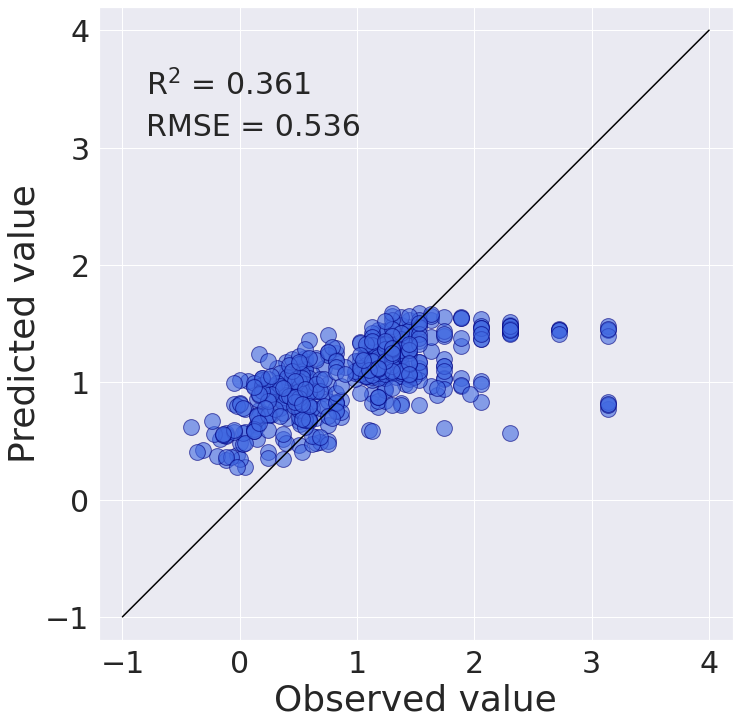

In [12]:
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',   
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-1,4],[-1,4],c='black')

plt.xlim(-1.2,4.2)
plt.ylim(-1.2,4.2)
x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed value",fontsize=36)
plt.ylabel("Predicted value",fontsize=36)
plt.tick_params(labelsize=30)
plt.text(-0.8,3.1,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(-0.8,3.45,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

In [13]:
np.save('../result/data2_Baseline_MG_GCN_y_val.npy',y_val)
np.save('../result/data2_Baseline_MG_GCN_y_pred.npy',y_pred)